___

<center><h1>Supply Chain Analysis</h1></center>

___

<center><h2>DSM020 - Data Programming in Python</h2></center><br>
<center><strong>Teacher:</strong> Sean McGrath </center>

___
<p></p>
<center style="color: #AA6373; font-weight: 400;"><strong>Presented by:</strong></center>
<center style="color: #AA6373; font-weight: 400;">Jorge Forero L.</center>
<center style="color: #AA6373; font-weight: 400;">Student Number: 240323983</center>
<center style="color: #AA6373; font-weight: 400;">Student Portal Username: JEFL1</center>
<center>August 2024</center>
<p></p>

In [1]:
# Common Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import s3fs

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelling
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Testing and Evaluation
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV

## Data Understanding

This phase involves collecting the data, describing its attributes and performing the data exploratory analysis. For this coursework we use data that can be found in open data sources [1]. The data used to develop this project was selected given the requirements described by the instru ctor of the subject.

### Data Load

In [3]:
# Using the address for the .csv file from the GitHub repository
url = 'https://raw.githubusercontent.com/jforeroluque/Supply_Chain_Analysis/main/DataCoSupplyChainDataset.csv'

# Load the CSV file into a DataFrame, specifying the encoding
df_supply = pd.read_csv(url, encoding='ISO-8859-1', on_bad_lines='skip')

# Display the DataFrame
print(df_supply.head())

       Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   
2      CASH                         4                              4   
3     DEBIT                         3                              4   
4   PAYMENT                         2                              4   

   Benefit per order  Sales per customer   Delivery Status  \
0          91.250000          314.640015  Advance shipping   
1        -249.089996          311.359985     Late delivery   
2        -247.779999          309.720001  Shipping on time   
3          22.860001          304.809998  Advance shipping   
4         134.210007          298.250000  Advance shipping   

   Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0                   0           73  Sporting Goods        Caguas  ...   
1                   1           73  Sporting Goo

In [4]:
print(df_supply.columns)

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

### Volume of the data

In [6]:
# Records
num_records = len(df_supply)

# Features
num_features = len(df_supply.columns)

print(f"The dataset has {num_records} records and {num_features} features.")

The dataset has 180519 records and 53 features.


### Features explanation 

|Feature| Explanation|
|:-:|:---|
|Type| Type of transaction made
|Days for shipping (real)| Actual shipping days of the purchased product
|Days for shipment (scheduled)| Days of scheduled delivery of the purchased product
|Benefit per order| Earnings per order placed
|Sales per customer| Total sales per customer made per customer
|Delivery Status| Delivery status of orders| Advance shipping , Late delivery , Shipping canceled , Shipping on tim...
|Late_delivery_risk| Categorical variable that indicates if sending is late (1), it is not late (0).
|Category Id| Product category code
|Category Name| Description of the product category
|Customer City| City where the customer made the purchase
|Customer Country| Country where the customer made the purchase
|Customer Email| Customer's email
|Customer Fname| Customer name
|Customer Id| Customer ID
|Customer Lname| Customer lastname
|Customer Password| Masked customer key
|Customer Segment| Types of Customers| Consumer , Corporate , Home Office
|Customer State| State to which the store where the purchase is registered belongs
|Customer Street| Street to which the store where the purchase is registered belongs
|Customer Zipcode| Customer Zipcode
|Department Id| Department code of store
|Department Name| Department name of store
|Latitude| Latitude corresponding to location of store
|Longitude| Longitude corresponding to location of store
|Market| Market to where the order is delivered | Africa , Europe , LATAM , Pacific Asia , USCA
|Order City| Destination city of the order
|Order Country| Destination country of the order
|Order Customer Id| Customer order code
|order date (DateOrders)| Date on which the order is made
|Order Id| Order code
|Order Item Cardprod Id| Product code generated through the RFID reader
|Order Item Discount| Order item discount value
|Order Item Discount Rate| Order item discount percentage
|Order Item Id| Order item code
|Order Item Product Price| Price of products without discount
|Order Item Profit Ratio| Order Item Profit Ratio
|Order Item Quantity| Number of products per order
|Sales| Value in sales
|Order Item Total| Total amount per order
|Order Profit Per Order| Order Profit Per Order
|Order Region| Region of the world where the order is delivered | Southeast Asia ,South Asia ,Oceania ,Eastern ...
|Order State| State of the region where the order is delivered
|Order Status| Order Status | COMPLETE , PENDING , CLOSED , PENDING_PAYMENT ,CANCELED , PROCESSING ,SUSPECTED_FR...
|Product Card Id| Product code
|Product Category Id| Product category code
|Product Description| Product Description
|Product Image| Link of visit and purchase of the product
|Product Name| Product Name
|Product Price| Product Price
|Product Status| Status of the product stock |If it is 1 not available , 0 the product is available
|Shipping date (DateOrders)| Exact date and time of shipment
|Shipping Mode| The following shipping modes are presented | Standard Class , First Class , Second Class , Same D..."

## Exploratory Data Analysis

### Missing Values

We will be dropping the rows with missing values in the features that are the most relevant for the analysis we will be doing in this project. 

In [10]:
# Dropping rows with missing values in critical columns
df_cleaned = df_supply.dropna(subset=[
    "Late_delivery_risk",
    "Order Item Product Price",
    "Order Item Quantity",
    "Days for shipment (scheduled)",
    "Days for shipping (real)",
    "Customer Segment",
    "Order Country",
    "Shipping Mode"
])

# Show the first 5 rows of cleaned data
df_cleaned.head(5)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


#### Numerical Feature Summary

In [13]:
# Summary statistics
df_cleaned.describe()


,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,...,180519.000000,180519.000000,180519.000000,180519.000000,24840.000000,180519.000000,180519.000000,0.0,180519.000000,180519.0
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,...,2.127638,203.772096,183.107609,21.974989,55426.132327,692.509764,31.851451,NaN,141.232550,0.0
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,...,1.453451,132.273077,120.043670,104.433526,31919.279101,336.446807,15.640064,NaN,139.732492,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,...,1.000000,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,...,1.000000,119.980003,104.379997,7.000000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,...,1.000000,199.919998,163.990005,31.520000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,...,3.000000,299.950012,247.399994,64.800003,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,...,5.000000,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


#### Categorical Feature Summary

Here we assess the distribution of values across categorical features and identifying missing data

In [16]:
# Set the count to distinct values in each categorical feature
for col_name in ['Shipping Mode', 'Order Region', 'Order Country', 'Product Category Id', 'Customer Segment', 'Order Status', 'Market']:
    print(f"\nDistinct counts for {col_name}:")
    print(df_cleaned[col_name].value_counts())



Distinct counts for Shipping Mode:
Shipping Mode
Standard Class    107752
Second Class       35216
First Class        27814
Same Day            9737
Name: count, dtype: int64

Distinct counts for Order Region:
Order Region
Central America    28341
Western Europe     27109
South America      14935
Oceania            10148
Northern Europe     9792
Southeast Asia      9539
Southern Europe     9431
Caribbean           8318
West of USA         7993
South Asia          7731
Eastern Asia        7280
East of USA         6915
West Asia           6009
US Center           5887
South of  USA       4045
Eastern Europe      3920
West Africa         3696
North Africa        3232
East Africa         1852
Central Africa      1677
Southern Africa     1157
Canada               959
Central Asia         553
Name: count, dtype: int64

Distinct counts for Order Country:
Order Country
Estados Unidos       24840
Francia              13222
México               13172
Alemania              9564
Australia        

In [17]:
# Count the number of missing values in each column to be sure
print("\nMissing values in each column:")
print(df_cleaned.isnull().sum())


Missing values in each column:
Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market  

##### Removing Unnecessary Columns

We Remove unnecessary columns that won't be considered for the analysis

In [18]:
# List of columns to drop
columns_to_drop = [
    'Customer Email', 'Customer Fname', 'Customer Id',
    'Customer Lname', 'Customer Password', 'Customer Street',
    'Customer Zipcode', 'Product Description', 'Product Image'
]

# Drop the columns from the DataFrame
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Display the first few rows to confirm
df_cleaned.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,Java Occidental,COMPLETE,NaN,1360,73,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,Rajastán,PENDING,NaN,1360,73,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,Rajastán,CLOSED,NaN,1360,73,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,Queensland,COMPLETE,NaN,1360,73,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,Queensland,PENDING_PAYMENT,NaN,1360,73,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


#### Class Imbalance Analysis

Here we determine the distribution of the target feature "Late Delivery Risk" where we want to assess class imbalance that is a critical factor to implement Machine Learning Models

In [19]:
# Count the number of occurrences for each class in 'Late_delivery_risk'
late_delivery_counts = df_cleaned['Late_delivery_risk'].value_counts()

# Display the counts
print("Count of occurrences for each class in 'Late_delivery_risk':")
print(late_delivery_counts)

Count of occurrences for each class in 'Late_delivery_risk':
Late_delivery_risk
1    98977
0    81542
Name: count, dtype: int64


In [21]:
# Calculate the total number of records
total_count = len(df_cleaned)

# Calculate the percentage distribution
late_delivery_percentage = (late_delivery_counts / total_count) * 100

# Combine counts and percentages into a DataFrame
late_delivery_distribution = pd.DataFrame({
    'count': late_delivery_counts,
    'percentage': late_delivery_percentage
})

# Display the distribution
print("\nDistribution in terms of percentages:")
late_delivery_distribution


Distribution in terms of percentages:


,count,percentage
Late_delivery_risk,,
1,98977,54.829132
0,81542,45.170868


#### Correlation Analysis (Numerical Features)

Here we try to understand and identify the strength and direction of relationships between the numerical features and the target variable "Late Delivery Risk".

In [22]:
# List of numerical columns to calculate the correlation with 'Late_delivery_risk'
numerical_columns_corr = ['Days for shipment (scheduled)', 'Order Item Quantity', 'Latitude', 'Longitude', 'Order Item Total', 'Sales', 'Order Item Product Price']

# Ensure 'Late_delivery_risk' is numeric for correlation (if needed)
df_cleaned['Late_delivery_risk'] = pd.to_numeric(df_cleaned['Late_delivery_risk'], errors='coerce')

# Calculate and print the correlation for each numerical column with 'Late_delivery_risk'
for col_name in numerical_columns_corr:
    correlation = df_cleaned[[col_name, 'Late_delivery_risk']].corr().iloc[0, 1]
    print(f"Correlation between {col_name} and Late_delivery_risk: {correlation}")

Correlation between Days for shipment (scheduled) and Late_delivery_risk: -0.3693517719633493
Correlation between Order Item Quantity and Late_delivery_risk: -0.00013923280125116905
Correlation between Latitude and Late_delivery_risk: 0.000678944387310896
Correlation between Longitude and Late_delivery_risk: -0.0019148783287543077
Correlation between Order Item Total and Late_delivery_risk: -0.0037912615226316356
Correlation between Sales and Late_delivery_risk: -0.003564360506914072
Correlation between Order Item Product Price and Late_delivery_risk: -0.002175249056545577


#### Visualizations

Here we intend to achieve visual insights into the distribution of the Late Dalivery Risk and its relationship with Shipping Mode


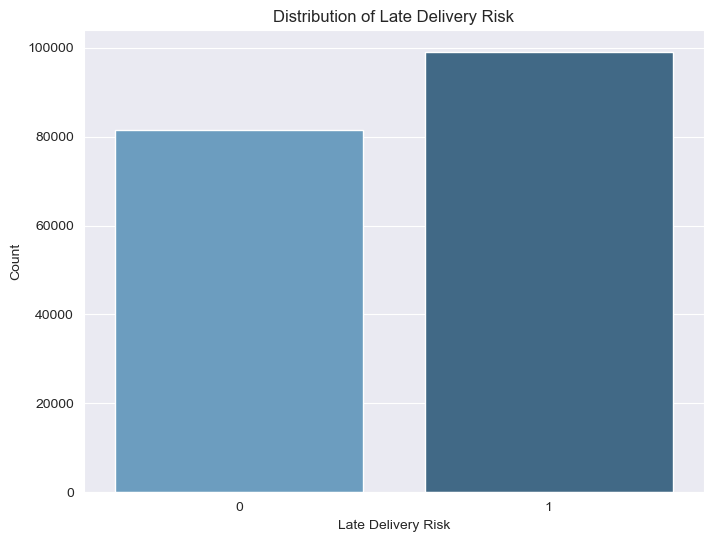

In [24]:
 # Count occurrences of 'Late_delivery_risk' using pandas
late_delivery_risk_df = df_cleaned.groupby("Late_delivery_risk").size().reset_index(name='count')

# Plot Late Delivery Risk using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Late_delivery_risk', y='count', hue='Late_delivery_risk', data=late_delivery_risk_df, palette='Blues_d', legend=False)
plt.xlabel('Late Delivery Risk')
plt.ylabel('Count')
plt.title('Distribution of Late Delivery Risk')
plt.show()

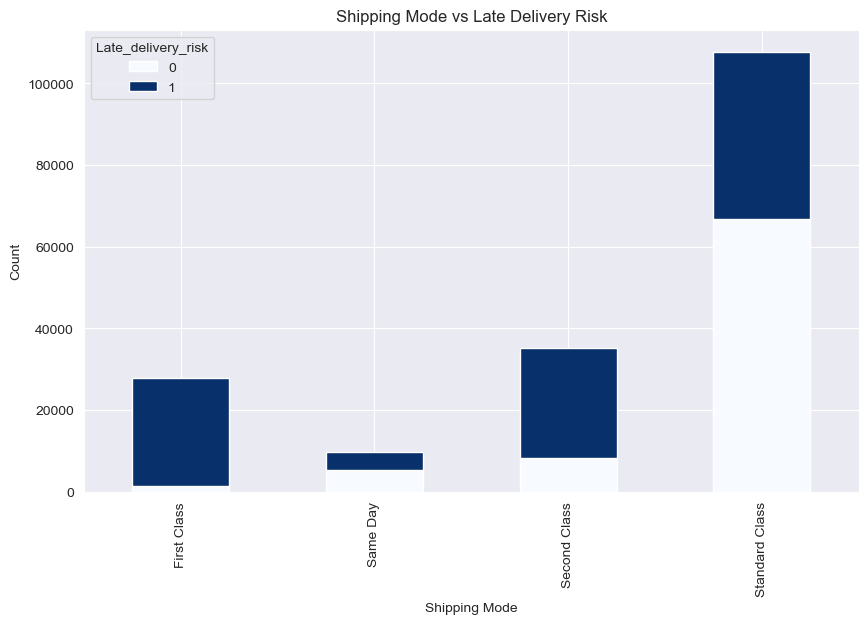

In [25]:
# Count occurrences of 'Shipping Mode' and 'Late_delivery_risk' using pandas
shipping_mode_df = df_cleaned.groupby(["Shipping Mode", "Late_delivery_risk"]).size().reset_index(name='count')

# Create a pivot table for visualization
shipping_mode_pivot = shipping_mode_df.pivot(index='Shipping Mode', columns='Late_delivery_risk', values='count')

# Plot Shipping Mode vs Late Delivery using seaborn
shipping_mode_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Blues')
plt.title("Shipping Mode vs Late Delivery Risk")
plt.ylabel("Count")
plt.show()

#### Shipping mode Analysis

This analysis would enable to evaluate the Shipping mode performance by looking at how frequently late daliveries occur for each shipping method. With this the company can determine which shipping methods may require optimization or further investigation to reduce late deliveries.

In [27]:
# Group by 'Shipping Mode' and calculate the number of late deliveries and total deliveries
shipping_mode_analysis = df_cleaned.groupby('Shipping Mode').agg(
    Late_Delivery_Count=pd.NamedAgg(column='Late_delivery_risk', aggfunc=lambda x: (x == 1).sum()),
    Total_Deliveries=pd.NamedAgg(column='Late_delivery_risk', aggfunc='size')
).reset_index()

# Calculate the percentage of late deliveries for each shipping mode
shipping_mode_analysis['Late_Delivery_Percentage'] = (shipping_mode_analysis['Late_Delivery_Count'] / shipping_mode_analysis['Total_Deliveries']) * 100

# Display the result
shipping_mode_analysis

,Shipping Mode,Late_Delivery_Count,Total_Deliveries,Late_Delivery_Percentage
0,First Class,26513,27814,95.322499
1,Same Day,4454,9737,45.743042
2,Second Class,26987,35216,76.632781
3,Standard Class,41023,107752,38.071683


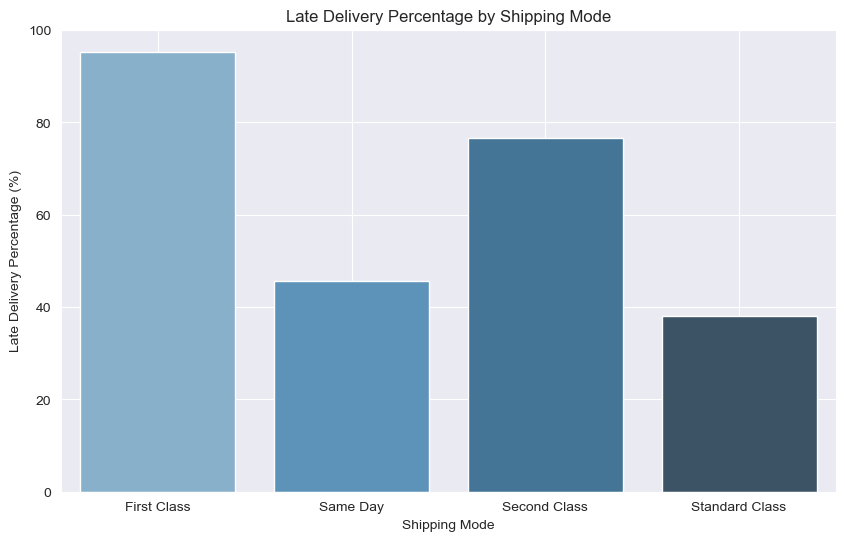

In [31]:
# Set up the figure size
plt.figure(figsize=(10, 6))

sns.barplot(x="Shipping Mode", y="Late_Delivery_Percentage", hue='Shipping Mode', data=shipping_mode_analysis, palette='Blues_d')

plt.xlabel('Shipping Mode')
plt.ylabel('Late Delivery Percentage (%)')
plt.title('Late Delivery Percentage by Shipping Mode')
plt.grid(True)

# Show the plot
plt.show()

#### Geographical Analysis

This analysis evaluates geographical impact on the late daliveries by breaking down the data by Market, Order City, and Order Country. With this the company can understand which regions are experiencing more late deliveries.

In [35]:
# Group by 'Market', 'Order City', and 'Order Country' and calculate late deliveries and total deliveries
geo_analysis = df_cleaned.groupby(['Market', 'Order City', 'Order Country']).agg(
    Late_Delivery_Count=pd.NamedAgg(column='Late_delivery_risk', aggfunc=lambda x: (x == 1).sum()),
    Total_Deliveries=pd.NamedAgg(column='Late_delivery_risk', aggfunc='size')
).reset_index()

# Calculate the percentage of late deliveries
geo_analysis['Late_Delivery_Percentage'] = (geo_analysis['Late_Delivery_Count'] / geo_analysis['Total_Deliveries']) * 100

# Sort by Late_Delivery_Count in descending order
geo_analysis = geo_analysis.sort_values(by='Late_Delivery_Count', ascending=False)

# Display the result without truncation
pd.set_option('display.max_rows', None)  # Ensure all rows are shown
pd.set_option('display.max_columns', None)  # Ensure all columns are shown
pd.set_option('display.width', None)  # Adjust display width

# Show the result
geo_analysis

,Market,Order City,Order Country,Late_Delivery_Count,Total_Deliveries,Late_Delivery_Percentage
3444,USCA,New York City,Estados Unidos,1261,2202,57.266122
2118,LATAM,Santo Domingo,República Dominicana,1217,2211,55.042967
3379,USCA,Los Angeles,Estados Unidos,965,1845,52.303523
2161,LATAM,Tegucigalpa,Honduras,942,1783,52.832305
1917,LATAM,Managua,Nicaragua,925,1682,54.994055
1938,LATAM,Mexico City,México,803,1484,54.110512
2710,Pacific Asia,Manila,Filipinas,766,1381,55.467053
3562,USCA,San Francisco,Estados Unidos,706,1297,54.433308
2097,LATAM,San Salvador,El Salvador,668,1135,58.854626
3493,USCA,Philadelphia,Estados Unidos,657,1302,50.460829


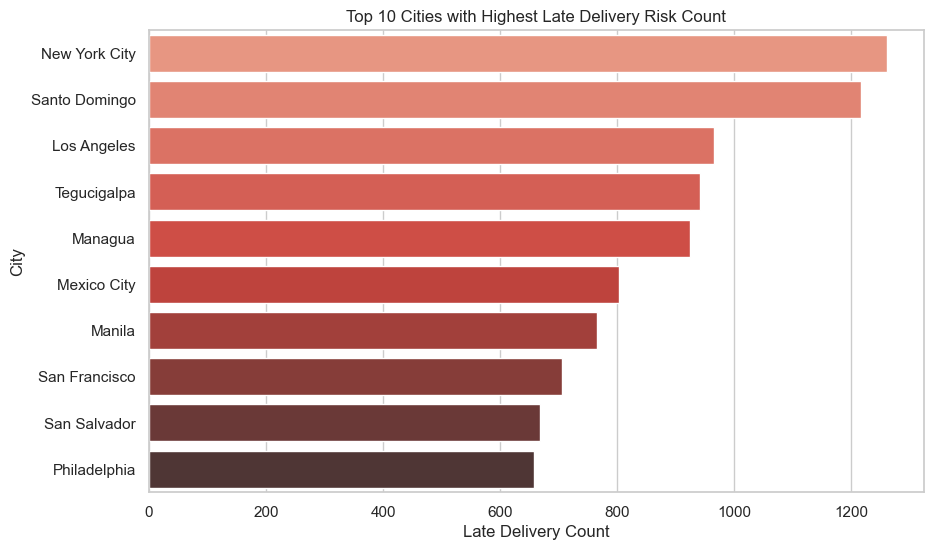

In [41]:
# Set seaborn style
sns.set(style="whitegrid")

# Top 10 Cities by Late Delivery Count
top_cities = geo_analysis.sort_values(by='Late_Delivery_Count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Late_Delivery_Count', y='Order City', hue='Order City', data=top_cities, palette='Reds_d')
plt.title('Top 10 Cities with Highest Late Delivery Risk Count')
plt.xlabel('Late Delivery Count')
plt.ylabel('City')
plt.show()

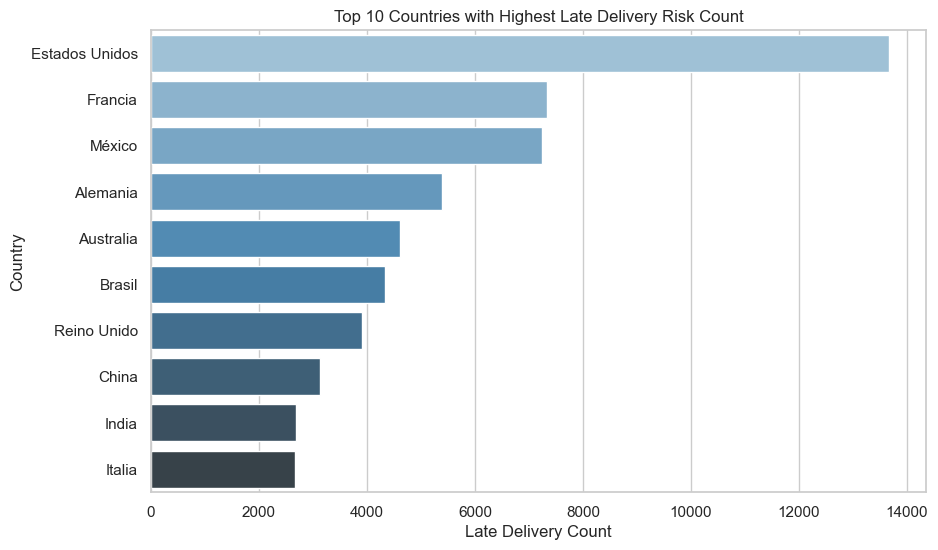

In [40]:
# Top 10 Countries by Late Delivery Count
top_countries = geo_analysis.groupby('Order Country').agg(
    Late_Delivery_Count=pd.NamedAgg(column='Late_Delivery_Count', aggfunc='sum'),
    Total_Deliveries=pd.NamedAgg(column='Total_Deliveries', aggfunc='sum')
).reset_index()

top_countries = top_countries.sort_values(by='Late_Delivery_Count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Late_Delivery_Count', y='Order Country', hue='Order Country', data=top_countries, palette='Blues_d')
plt.title('Top 10 Countries with Highest Late Delivery Risk Count')
plt.xlabel('Late Delivery Count')
plt.ylabel('Country')
plt.show()

#### Product Category Analysis

Here we evaluate the imact of the product categories on late deliveries. With this we aim to identify which product categories are more prone to late deliveries, offering insights into potential logistical inefficiencies for certain products.

In [46]:
# Group by 'Category Name' and calculate late deliveries and total deliveries
product_category_analysis = df_cleaned.groupby('Category Name').agg(
    Late_Delivery_Count=pd.NamedAgg(column='Late_delivery_risk', aggfunc=lambda x: (x == 1).sum()),
    Total_Deliveries=pd.NamedAgg(column='Late_delivery_risk', aggfunc='size')
).reset_index()

# Calculate the percentage of late deliveries for each product category
product_category_analysis['Late_Delivery_Percentage'] = (product_category_analysis['Late_Delivery_Count'] / product_category_analysis['Total_Deliveries']) * 100

# Sort by Late_Delivery_Count in descending order
product_category_analysis = product_category_analysis.sort_values(by='Late_Delivery_Count', ascending=False)

# Display the result
product_category_analysis

,Category Name,Late_Delivery_Count,Total_Deliveries,Late_Delivery_Percentage
12,Cleats,13496,24551,54.971284
34,Men's Footwear,12121,22246,54.486200
47,Women's Apparel,11476,21035,54.556691
30,Indoor/Outdoor Games,10565,19298,54.746606
18,Fishing,9516,17325,54.926407
46,Water Sports,8517,15540,54.806950
9,Camping & Hiking,7487,13729,54.534198
10,Cardio Equipment,6805,12487,54.496677
38,Shop By Sport,6058,10984,55.152950
17,Electronics,1770,3156,56.083650


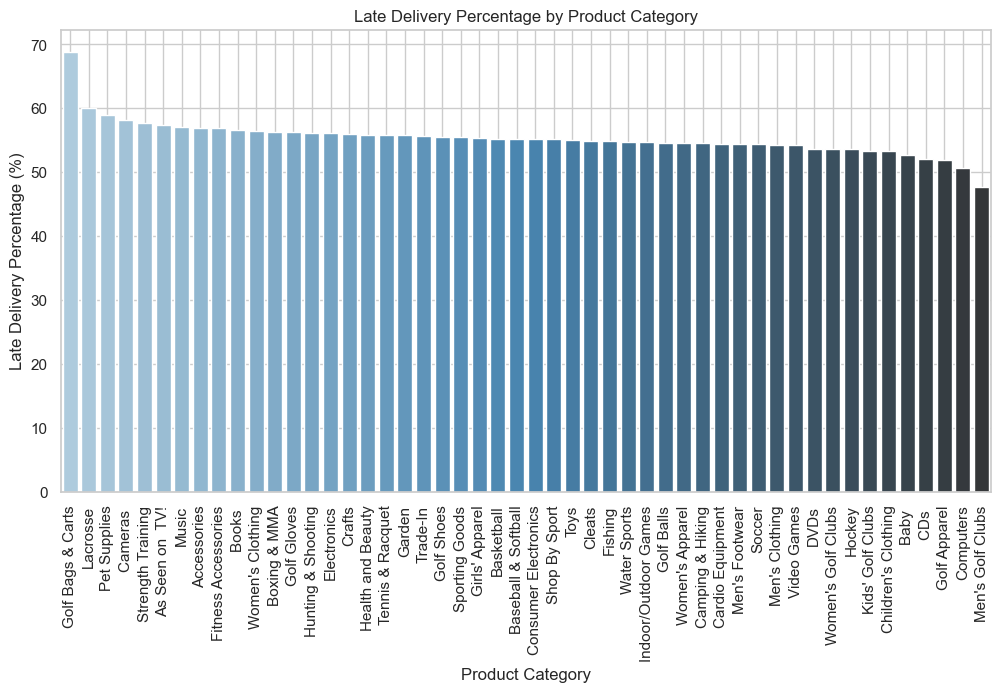

In [47]:
# Sort the data by Late_Delivery_Percentage in descending order
product_category_analysis = product_category_analysis.sort_values(by="Late_Delivery_Percentage", ascending=False)

# Set seaborn style
sns.set(style="whitegrid")

# Create a bar plot using seaborn with hue and palette
plt.figure(figsize=(12, 6))
sns.barplot(x="Category Name", y="Late_Delivery_Percentage", data=product_category_analysis, palette="Blues_d", hue="Category Name")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Product Category')
plt.ylabel('Late Delivery Percentage (%)')
plt.title('Late Delivery Percentage by Product Category')

# Add gridlines
plt.grid(True)

# Show the plot
plt.show()